In [1]:
import pandas as pd
from print_nanny_webapp.client_events.models import PredictEvent, AlertVideoMessage, PrintJob
from django.utils import timezone
from asgiref.sync import sync_to_async
import os
import uuid

import matplotlib


WARNING 2020-11-19 12:10:18,890 __init__ 50 140712647333696 Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hbvgot91 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
CONFIDENCE_THRESHOLD = 0.50

LABELS = {
    1: 'nozzle',
    2: 'adhesion',
    3: 'spaghetti',
    4: 'print',
    5: 'raft',
}

FAILURES = {
    2: 'adhesion',
    3: 'spaghetti',  
}


In [3]:
import json
def dict_to_series(data):
    return pd.Series(data.values(), index=data.keys())

In [4]:
predict_events = PredictEvent.objects.all().order_by('-dt').values('id','predict_data')

df = pd.DataFrame.from_records(predict_events, index='id')
df = df['predict_data'].apply(dict_to_series)

NUM_DETECTIONS = len(df['detection_scores'].iloc[0])
print(NUM_DETECTIONS)

40


In [5]:
df = df.dropna()
df = df[['detection_classes', 'detection_scores']]
df = df.reset_index()
df = df.rename(columns={'id': 'frame_id' })

NUM_FRAMES = len(df)
df

frame_id                                  detection_classes  \
0         80  [4, 1, 3, 3, 1, 4, 3, 4, 3, 4, 4, 3, 3, 4, 3, ...   
1         79  [3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, ...   
2         78  [3, 3, 3, 4, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, ...   
3         77  [3, 1, 3, 4, 3, 4, 3, 1, 3, 3, 3, 4, 3, 3, 4, ...   
4         76  [4, 4, 4, 3, 3, 4, 1, 4, 4, 3, 4, 4, 4, 3, 1, ...   
..       ...                                                ...   
75         5  [4, 5, 1, 5, 1, 4, 5, 5, 4, 5, 4, 4, 4, 4, 1, ...   
76         4  [4, 5, 1, 5, 5, 1, 4, 5, 1, 4, 4, 5, 1, 4, 1, ...   
77         3  [4, 4, 1, 5, 4, 5, 5, 4, 4, 4, 4, 4, 4, 2, 4, ...   
78         2  [4, 5, 1, 1, 5, 5, 4, 4, 4, 1, 4, 5, 2, 5, 4, ...   
79         1  [4, 5, 1, 1, 5, 4, 5, 5, 5, 1, 1, 1, 4, 5, 4, ...   

                                     detection_scores  
0   [0.73046875, 0.58203125, 0.41796875, 0.1210937...  
1   [0.66015625, 0.01953125, 0.01171875, 0.0117187...  
2   [0.7890625, 0.03515625, 0.03515625, 0.03515625...  
3   [0.58203125, 0.02734375, 0.02734375, 0.0273437...  
4   [0.58203125, 0.12109375, 0.08984375, 0.0507812...  
..                                                ...  
75  [0.83984375, 0.73046875, 0.58203125, 0.0664062...  
76  [0.7890625, 0.66015625, 0.5, 0.2109375, 0.2109...  
77  [0.73046875, 0.5, 0.26953125, 0.26953125, 0.12...  
78  [0.7890625, 0.7890625, 0.58203125, 0.06640625,...  
79  [0.83984375, 0.73046875, 0.5, 0.06640625, 0.05...  

[80 rows x 3 columns]

In [6]:
print('Explode detection_classes and detection_scores together')
df = df.set_index(['frame_id']).apply(pd.Series.explode).reset_index()

assert len(df) == NUM_FRAMES * NUM_DETECTIONS
df

Explode detection_classes and detection_scores together


frame_id detection_classes detection_scores
0           80                 4         0.730469
1           80                 1         0.582031
2           80                 3         0.417969
3           80                 3         0.121094
4           80                 1        0.0664062
...        ...               ...              ...
3195         1                 5        0.0078125
3196         1                 1        0.0078125
3197         1                 4        0.0078125
3198         1                 3        0.0078125
3199         1                 4        0.0078125

[3200 rows x 3 columns]

In [7]:
print('Add labels')
df['label'] = df['detection_classes'].map(LABELS)
df


Add labels


frame_id detection_classes detection_scores      label
0           80                 4         0.730469      print
1           80                 1         0.582031     nozzle
2           80                 3         0.417969  spaghetti
3           80                 3         0.121094  spaghetti
4           80                 1        0.0664062     nozzle
...        ...               ...              ...        ...
3195         1                 5        0.0078125       raft
3196         1                 1        0.0078125     nozzle
3197         1                 4        0.0078125      print
3198         1                 3        0.0078125  spaghetti
3199         1                 4        0.0078125      print

[3200 rows x 4 columns]

In [8]:
print('Create a hierarchal index')
df = df.set_index(['frame_id', 'label'])
df

Create a hierarchal index


detection_classes detection_scores
frame_id label                                       
80       print                     4         0.730469
         nozzle                    1         0.582031
         spaghetti                 3         0.417969
         spaghetti                 3         0.121094
         nozzle                    1        0.0664062
...                              ...              ...
1        raft                      5        0.0078125
         nozzle                    1        0.0078125
         print                     4        0.0078125
         spaghetti                 3        0.0078125
         print                     4        0.0078125

[3200 rows x 2 columns]

INFO 2020-11-19 12:10:19,111 font_manager 50 140712647333696 Generating new fontManager, this may take some time...


Distribution of confidences


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

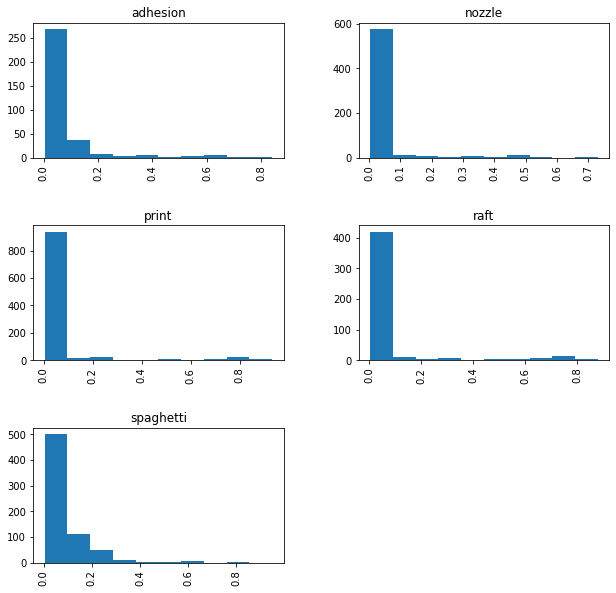

In [9]:
print(f'Distribution of confidences')
df['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidences > 0.5


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

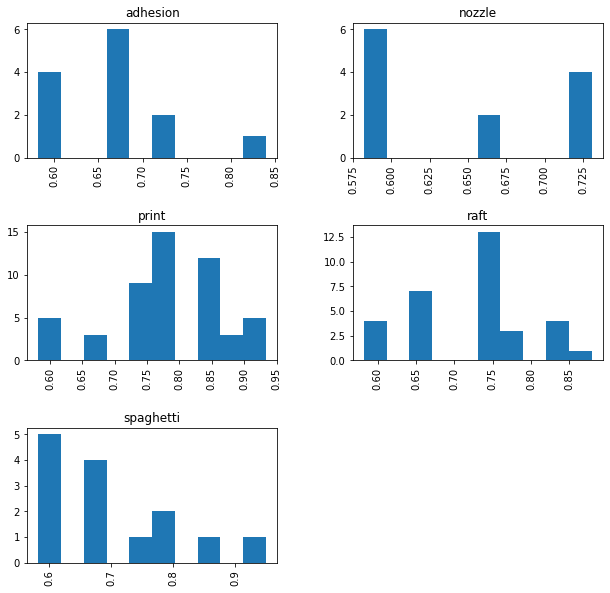

In [10]:
print(f'Distribution of confidences > {CONFIDENCE_THRESHOLD}')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidence scores > THRESHOLD, FAILURE vs. OK


array([<AxesSubplot:title={'center':'FAILURE'}>,
       <AxesSubplot:title={'center':'NEUTRAL'}>], dtype=object)

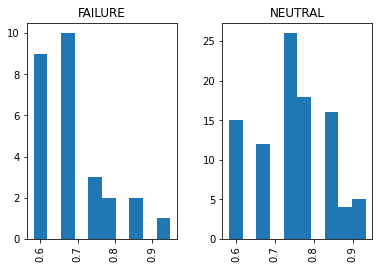

In [11]:
print('Distribution of confidence scores > THRESHOLD, FAILURE vs. OK')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by=lambda x: 'FAILURE' if x[1] in FAILURES.values() else 'NEUTRAL' )


In [12]:
print('Frames where at least 1 type of failure is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (df['detection_classes'].isin(FAILURES))

fail_df = df[mask]

fail_df

Frames where at least 1 type of failure is confidently detected


detection_classes detection_scores
frame_id label                                       
79       spaghetti                 3         0.660156
78       spaghetti                 3         0.789062
77       spaghetti                 3         0.582031
75       spaghetti                 3         0.730469
74       spaghetti                 3         0.839844
73       spaghetti                 3         0.582031
72       spaghetti                 3         0.582031
69       adhesion                  2         0.660156
         adhesion                  2         0.582031
68       adhesion                  2         0.660156
67       spaghetti                 3         0.582031
66       spaghetti                 3         0.660156
65       adhesion                  2         0.839844
         adhesion                  2         0.660156
63       adhesion                  2         0.730469
         adhesion                  2         0.582031
61       adhesion                  2         0.582031
60       adhesion                  2         0.730469
         adhesion                  2         0.660156
59       adhesion                  2         0.660156
         adhesion                  2         0.582031
58       spaghetti                 3         0.789062
         spaghetti                 3         0.582031
57       spaghetti                 3         0.949219
         spaghetti                 3         0.660156
         adhesion                  2         0.660156
32       spaghetti                 3         0.660156

In [13]:
print('Percent of frames where at least 1 type of failure is confidently detected')
(len(fail_df) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of failure is confidently detected


33.75

In [14]:
print('Frames where at least 1 type of neutral is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (~df['detection_classes'].isin(FAILURES))

neutral_df = df[mask]

neutral_df 

Frames where at least 1 type of neutral is confidently detected


detection_classes detection_scores
frame_id label                                    
80       print                  4         0.730469
         nozzle                 1         0.582031
76       print                  4         0.582031
74       print                  4         0.910156
73       print                  4         0.660156
...                           ...              ...
2        print                  4         0.789062
         raft                   5         0.789062
         nozzle                 1         0.582031
1        print                  4         0.839844
         raft                   5         0.730469

[96 rows x 2 columns]

In [15]:
print('Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected')
(len(neutral_df ) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected


120.0

In [16]:
print('Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected')

len(fail_df) / (len(neutral_df ))

Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected


0.28125

In [17]:
tuple(df[df['detection_scores'] > CONFIDENCE_THRESHOLD].groupby(level='label').size().items())

(('adhesion', 13),
 ('nozzle', 12),
 ('print', 52),
 ('raft', 32),
 ('spaghetti', 14))

finished 0/18
finished 1/18
finished 2/18
finished 3/18
finished 4/18
finished 5/18
finished 6/18
finished 7/18
finished 8/18
finished 9/18
finished 10/18
finished 11/18
finished 12/18
finished 13/18
finished 14/18
finished 15/18
finished 16/18
finished 17/18


1